# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
from pandas.io.parsers import read_csv

training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Load id -> signname mapping file
signnames = read_csv("signnames.csv").values[:, 1]

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_train)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape
train_shape = X_train.shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Train set shape =", train_shape)
print("Number of classes =", n_classes)
for i in range(5):
    print(y_test[i])

Number of training examples = 39209
Number of testing examples = 39209
Image data shape = (32, 32, 3)
Train set shape = (39209, 32, 32, 3)
Number of classes = 43
16
1
38
33
11


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [ ]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy as np
import random

# Visualizations will be shown in the notebook.
%matplotlib inline

sign_classes, index_start_of_classes, class_counts = np.unique(y_train, return_index = True, return_counts = True)

for sign_class, class_index_start, class_count in zip(sign_classes, index_start_of_classes, class_counts):
    fig = plt.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1.5, bottom = 0, top = 1.5, hspace = 0.05, wspace = 0.05)
    
    # Since the images is ordered by class, this line creates 10 random numbers in range (class_index_start , class_index_start + class_count)
    # to generate the indices for 10 random images. 
    random_indices = random.sample(range(class_index_start, class_index_start + class_count), 10)
    
    for i in range(10):
        axis = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
        if i == 0:
            axis.text(x = -160, y = 5, s = "Class %i: %s\n\n%s images" % (sign_class, signnames[sign_class], str(class_count)), rotation = 0, va = "top")
        axis.imshow(X_train[random_indices[i]])

    plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)


Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

no file found. preprocess started...
create new file
number of X_test_pre 12630
number of X_train_pre 39209


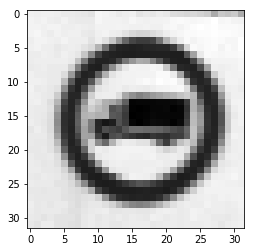

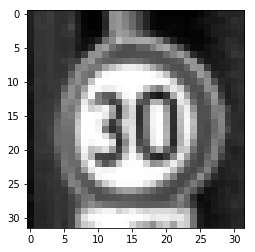

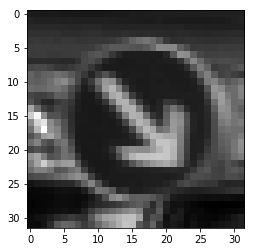

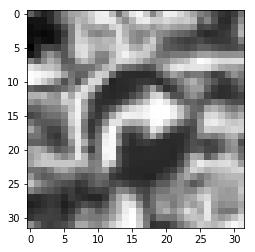

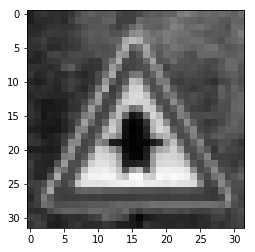

--------------------------------------------------


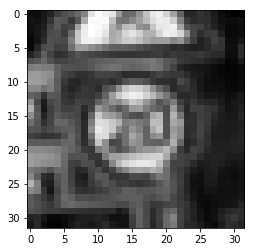

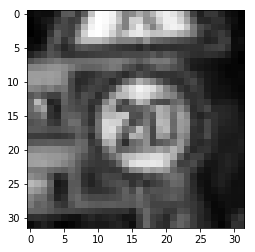

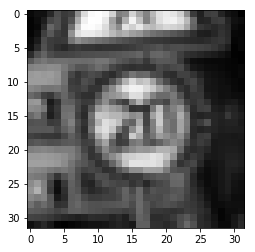

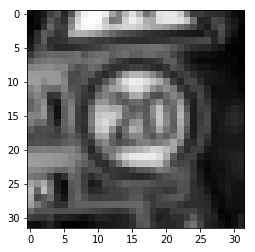

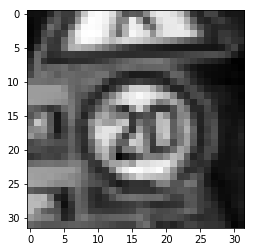

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle
import os

from skimage import exposure
import warnings 

# from sklearn.model_selection import train_test_split
# # Split from train data to create a set of validation data
# # The split is made randomly and renders the remaining train dataset shuffled.
# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20)

def grayscale_image(img):
    # Took this function from P1 (Lane finder project)
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def grayscale_dataset(X):
    """ Returns a new set with dimansion (?, 32, 32, 1)"""
    X_temp = np.empty([0, 32, 32, 1], dtype = np.int32)

    for i in range(X.shape[0]):
        gray = grayscale_image(X[i])
        gray = gray.reshape(gray.shape + (1,))
        X_temp = np.append(X_temp, [gray[:, :, :1]], axis = 0)

    return X_temp

def normalize_dataset(X):
    X = ((X-128) / 128.).astype(np.float32)
#     X = (X / 255.).astype(np.float32) # Using this makes the images look much better...?

    return X

def preprocess_dataset(X):
    X = grayscale_dataset(X)
    X = normalize_dataset(X)
   
    return X
 
    

# X_T = normalize_dataset(X_T)

# def load_or_preprocess_all_datasets():
#     import os
# import pickle

# ------------------------------------------------------------------
# # Load pickled data
# import pickle
# from pandas.io.parsers import read_csv

# training_file = "traffic-signs-data/train.p"
# testing_file = "traffic-signs-data/test.p"

# with open(training_file, mode='rb') as f:
#     train = pickle.load(f)
# with open(testing_file, mode='rb') as f:
#     test = pickle.load(f)
    
# X_train, y_train = train['features'], train['labels']
# X_test, y_test = test['features'], test['labels']
# ------------------------------------------------------------------

def read_pickle(file_path):
#     path = 'preprocessed_traffic-signs-data/'
#     preprocessed_train_file = path + 'preprocessed_train.p'
#     preprocessed_test_file = path + 'preprocessed_test.p'
    
    if os.path.isfile(file_path):
        with open(file_path, "rb") as f:
            try:
                print("file found and loaded")
                return pickle.load(f)
            except StandardError: # so many things could go wrong, can't be more specific.
                pass
    
    return False



def acquire_preprocessed_data():
    global test_preprocessed
    
    path = 'preprocessed_traffic-signs-data/'
    preprocessed_data_file = path + 'preprocessed_features.p'
#     preprocessed_test_file = path + 'preprocessed_test.p'
    
    preprocessed_data = read_pickle(preprocessed_data_file)
    if(preprocessed_data):
        print('file found and loaded')
    else:
        print('no file found. preprocess started...')
        X_test_preprocessed = preprocess_dataset(X_test)
        X_train_preprocessed = preprocess_dataset(X_train)
        test_preprocessed = {"features":X_test_preprocessed, 'labels':y_test}
        train_preprocessed = {"features":X_train_preprocessed, 'labels':y_train}
        preprocessed_data = {'test':test_preprocessed, 'train':train_preprocessed}
        
        print('create new file')    
        with open(preprocessed_data_file, "wb") as f:
            pickle.dump(preprocessed_data, f)
        
#     print('number of test preprocessed %i' % preprocessed['features'].shape[0])
    
    return preprocessed_data


# def read_or_new_pickle():
    
    
#     path = 'preprocessed_traffic-signs-data/'
#     preprocessed_train_file = path + 'preprocessed_train.p'
#     preprocessed_test_file = path + 'preprocessed_test.p'
    
#     if os.path.isfile(preprocessed_test_file):
#         with open(preprocessed_test_file, "rb") as f:
#             try:
#                 print("file found and loaded")
#                 return pickle.load(f)
#             except StandardError: # so many things could go wrong, can't be more specific.
#                 pass
    
#     print("no file found. preprocess started.")
#     X_test_preprocessed = preprocess_dataset(X_test)
#     y_test_preprocessed = preprocess_dataset(y_test)
    
#     test_preprocessed = {"features":X_test_preprocessed, 'labels':y_test_preprocessed}
        
#     print('create new file')
#     with open(preprocessed_test_file, "wb") as f:
#         pickle.dump(test_preprocessed, f)
        
#     return test_processed
    
#     with open(training_file, mode='rb') as f:
#     train = pickle.load(f)
# with open(testing_file, mode='rb') as f:
#     test = pickle.load(f)
    
    
# X_T = X_validation

preprocessed_data = acquire_preprocessed_data()
test_prep = preprocessed_data['test']
train_prep = preprocessed_data['train']
X_test_prep = test_prep['features']
X_train_prep = train_prep['features']
y_test_prep = test_prep['labels']
y_train_prep = train_prep['labels']

print('number of X_test_pre %i' % X_test_prep.shape[0])
print('number of X_train_pre %i' % X_train_prep.shape[0])

for i in range(5):
    img = X_test_prep[i]
    img = np.reshape(img, (32,32))
#     plt.imshow(img)
    plt.imshow(img, cmap = plt.get_cmap('gray'))
#     print(img)
    plt.show()

print('--------------------------------------------------')

for i in range(5):
    img = X_train_prep[i]
    img = np.reshape(img, (32,32))
#     plt.imshow(img)
    plt.imshow(img, cmap = plt.get_cmap('gray'))
#     print(img)
    plt.show()
    

### Split Data into Training, Validation and Testing Sets

In [ ]:
### Split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

from sklearn.model_selection import train_test_split
# Split from train data to create a set of validation data
# The split is made randomly and renders the remaining train dataset shuffled.
X_train_prep, X_validation_prep, y_train_prep, y_validation_prep = train_test_split(X_train_prep, y_train_prep, test_size=0.20)


### Model Architecture

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

EPOCHS = 10
BATCH_SIZE = 128

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    
    #input: 32x32x3
    conv1_3x3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 16), mean = mu, stddev = sigma))
    conv1_3x3_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_3x3_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_3x3_b
    conv1 = tf.nn.relu(conv1)
    #output: 32x32x16
    
    conv2_3x3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 16), mean = mu, stddev = sigma))
    conv2_3x3_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_3x3_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_3x3_b
    conv2 = tf.nn.relu(conv2)
    #output: 32x32x16
    
    maxpool1 = tf.nn.max_pool( conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding='SAME')
    # output: 16x16x16
    
    conv3_3x3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 32), mean = mu, stddev = sigma))
    conv3_3x3_b = tf.Variable(tf.zeros(32))
    conv3   = tf.nn.conv2d(maxpool1, conv3_3x3_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_3x3_b
    conv3 = tf.nn.relu(conv3)
    #output: 16x16x32
    
    conv4_3x3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
    conv4_3x3_b = tf.Variable(tf.zeros(64))
    conv4   = tf.nn.conv2d(conv3, conv4_3x3_W, strides=[1, 1, 1, 1], padding='SAME') + conv4_3x3_b
    conv4 = tf.nn.relu(conv4)
    
    maxpool2 = tf.nn.max_pool( conv4, ksize = [1,2,2,1], strides = [1,2,2,1], padding='SAME')
    # output 8x8x64
    print(maxpool2.get_shape())
    
    maxpool1_flat = flatten(maxpool1)
    
    maxpool2_flat = flatten(maxpool2)
    
    # SOLUTION: Flatten. Input 8x8x64. Output = 4096
    fc0   = tf.concat(1, [maxpool1_flat, maxpool2_flat])
    print(fc0.get_shape())
#     inception2 = tf.nn.relu(tf.concat(3, [conv2_1, conv2_2,conv2_3,conv2_4]))
    
    
    # SOLUTION: Layer 3: Fully Connected. Input = 432. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(8192, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 43.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 43), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    
#    
    return logits



In [ ]:
# features and labels
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
print("Number of classes =", n_classes)

# training pipeline
rate = 0.0001
keep_prob = tf.placeholder(tf.float32) # probability to keep units

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
print("done")


# model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# prediction
prediction = tf.argmax(logits,1)

softmax = tf.nn.softmax(logits)

# labels = tf.argmax(one_hot_y, 1)
topFiver = tf.nn.top_k(softmax, 5)

saver = tf.train.Saver()

def predict(X_data):
    sess = tf.get_default_session()
    predictions = sess.run(prediction, feed_dict={x: X_data, keep_prob: 1.0})
    return predictions

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def top_5(x_data, y_data):
    sess = tf.get_default_session()
    
    top_5_prob = sess.run(topFiver, feed_dict={x: x_data, keep_prob: 1.0})

    return top_5_prob
    

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [ ]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_prep, y_train_prep = shuffle(X_train_prep, y_train_prep)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_prep[offset:end], y_train_prep[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.8})
            
        validation_accuracy = evaluate(X_validation_prep, y_validation_prep)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_prep, y_test_prep)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

In [ ]:
# with tf.Session() as sess:
#     saver.restore(sess, tf.train.latest_checkpoint('.'))

#     test_accuracy = evaluate(X_custom_prep, y_custom)
#     print("Test Accuracy = {:.3f}".format(test_accuracy))

---

## Step 3: Test a Model on New Images

### Load and Output the Images

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

y_c = np.array([11,25,38,22,9,18,32,13,40,2,1])

X_c = np.empty([0, 32, 32, 3], dtype = np.int32)

for i in range(11):
    img_file = 'images/' + str(i+1) +'.png'
    img_arr = mpimg.imread(img_file)
    
    X_c = np.append(X_c, [img_arr[:,:,:3]], axis=0)
    
fig = plt.figure(figsize = (6, 1))
fig.subplots_adjust(left = 0, right = 1.5, bottom = 0, top = 1.5, hspace = 0.05, wspace = 0.05)
    
for i in range(11):
    axis = fig.add_subplot(1, 11, i+1, xticks=[], yticks=[])
    if i == 0:
        axis.text(x = -160, y = 5, s = "11 images of german traffic signs\nfound on the internet.", rotation = 0, va = "top")
    axis.imshow(X_c[i])

plt.show()

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    predictions = predict(X_c)
    
for prediction, image, correct_class in zip(predictions, X_c, y_c):
    plt.figure(figsize=(1,1))
    img = image.squeeze()
    plt.imshow(img)
    plt.show()
    if prediction == correct_class:
        print("Sign correctly predicted to be:%s" % signnames[prediction])
    else:
        print("Sign mistaken to be:%s" % signnames[prediction])
        print("Correct class is:%s" % signnames[correct_class])
    
    print("--------------------------")

### Analyze Performance

Calculating the accuracy for these 11 new images just like when accuracy was measured for the validation and test sets.

0 % accuracy does not sound right after 94 % on the test set. Examining the softmax values, its seems the network predicts toward the same classification for all 11 images. I tried running the code (for predictions and the top 5 softmax values) with some of the training data, and then it seemed to be working correctly. Either the network sucks, or more likely there is a bug somewhere.

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_custom_prep, y_custom)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    top_5_prob, top_5_indices = top_5(X_custom_prep, y_custom)


for probs, class_indices, image in zip(top_5_prob, top_5_indices, X_custom_prep):
    plt.figure(figsize=(1,1))
    img = image.squeeze()
    plt.imshow(img)
    plt.show()
    for prob, class_indice in zip(probs, class_indices):
        print("%0.2f percent probabilty of :%s" % (prob, signnames[class_indice]))
    
    print("--------------------------")


> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 